# Load data and check them
The goal of this notebook is to load data anche check if they are consistent.

In [2]:
%load_ext autoreload
%autoreload 2

## Import dependencies

(to check, a lot of unnecessary imports)

In [3]:
import os

import numpy as np
import matplotlib.pyplot as plt
import tqdm
import torch

from utils import save_as_npz, pltdataset, read_arr
#from functions.data_loader import *

## Read data

The data are stored in folders under the directory `../data`, in particular each folder contains several .dat files as follow:
```
├── dataL14
│   ├── evalues.dat
│   ├── speckleF.dat
│   └── speckleR.dat
├── dataL28
│   ├── evalues.dat
│   ├── speckleF.dat
│   └── speckleR.dat
└── ...
```
Each folder contains different data, both for shape and size. One has to handle this during reading. Once one has read the file they are saved as numpy standard format to speed up trainig, since in previous tests dataloading seems to be a bottleneck.

The following script load and save data in a dictionary-like file with the same name of the original folder, splitting trainig and test dataset (splitting between train and valuation set is performed on the fly during the training), with a 80:20 ratio.


In [3]:
data_path = "../data"

for path in tqdm.tqdm(os.listdir(data_path)):
    if path[-2:] == '28':
        data_size = 512
    elif path[-2:] == '56':
        data_size = 1024
    else:
        data_size = 256
    full_path = os.path.join(data_path, path)
    #print('\nfullpath {0}'.format(full_path))
    save_as_npz(full_path, data_size, seed=0, test_size=0.2)

  0%|          | 0/4 [00:00<?, ?it/s]
Saving train dataset as train_data_450k_L14

Saving test dataset as test_data_450k_L14
 25%|██▌       | 1/4 [15:45<47:15, 945.24s/it]
Saving train dataset as train_data_L14

Saving test dataset as test_data_L14
 50%|█████     | 2/4 [21:07<19:17, 578.51s/it]
Saving train dataset as train_data_L28

Saving test dataset as test_data_L28
 75%|███████▌  | 3/4 [26:22<07:38, 458.60s/it]
Saving train dataset as train_data_L56

Saving test dataset as test_data_L56
100%|██████████| 4/4 [31:40<00:00, 475.19s/it]


Data are now organized as follow:
```
├── train_dataL14.npz
├── test_dataL14.npz
├── train_dataL28.npz
├── test_dataL28.npz
└── ...
```
Where each file as the following numpy arrays `['evalues', 'speckleR', 'speckleF', 'x_axis', 'csi_axis']`. All the array are real except `speckleF`, which is complex.
Note that the sum of occurrence in the dataset is 150000, as we expected for `dataL14` files.

In [5]:
train_data = np.load('dataset/train_data_L56.npz')
test_data = np.load('dataset/test_data_L56.npz')

print('Arrays in training dataset {} with the following dtype and shape:\n'.format(train_data.files))

for key in train_data.files:
    print('{0} with type {1} and shape {2}'.format(key, train_data[key].dtype, train_data[key].shape))

print('\n\nArrays in test dataset {} with the following dtype and shape:\n'.format(test_data.files))

for key in test_data.files:
    print('{0} with type {1} and shape {2}'.format(key, test_data[key].dtype, test_data[key].shape)) 


Arrays in training dataset ['evalues', 'speckleR', 'speckleF', 'x_axis', 'csi_axis'] with the following dtype and shape:

evalues with type float64 and shape (30000,)
speckleR with type float64 and shape (30000, 1024)
speckleF with type complex128 and shape (30000, 1024)
x_axis with type float64 and shape (30000, 1024)
csi_axis with type float64 and shape (30000, 1024)


Arrays in test dataset ['evalues', 'speckleR', 'speckleF', 'x_axis', 'csi_axis'] with the following dtype and shape:

evalues with type float64 and shape (7500,)
speckleR with type float64 and shape (7500, 1024)
speckleF with type complex128 and shape (7500, 1024)
x_axis with type float64 and shape (7500, 1024)
csi_axis with type float64 and shape (7500, 1024)


## Check imported data

Lets briefly analize our dataset, in particular we look at their consistence, performing [torch.fft.fft](https://pytorch.org/docs/stable/generated/orch.fft.html#torch-fft) (Fast Fourier Trasform) to the `speckleR` and comparing with the `speckleF`.

difference beetween given fourier data and computed fourier data (real) tensor(0.0049, dtype=torch.float64)
difference beetween given fourier data and computed fourier data (imaginary) tensor(0.0048, dtype=torch.float64)
/home/scriva/miniconda3/envs/dl/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/scriva/miniconda3/envs/dl/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/scriva/miniconda3/envs/dl/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/scriva/miniconda3/envs/dl/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards 

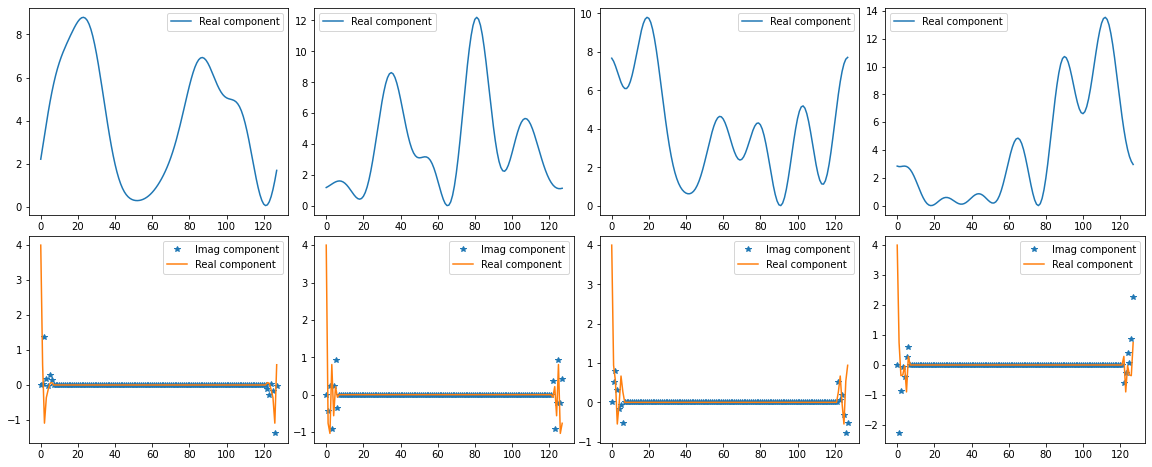

In [5]:
import torch.fft


speckleR = torch.from_numpy(train_data['speckleR'])
speckleF = torch.from_numpy(train_data['speckleF'])

speckle_fou = torch.fft.fft(speckleR, dim=1, norm='forward')
speckle_rfou = torch.fft.rfft(speckleR, dim=1, norm='forward')

print('difference beetween given fourier data and computed fourier data (real)', torch.mean(torch.sum(((speckleF.real - speckle_fou.real).abs()), dim=1)))
print('difference beetween given fourier data and computed fourier data (imaginary)', torch.mean(torch.sum(((speckleF.imag + speckle_fou.imag).abs()), dim=1)))

keys = ['speckleR', 'speckleF']
pltdataset(4, train_data, keys=keys)



Due a different definition of FFT beetween numpy/pytorch and the original data we have
$$ F[V_x](\xi) = -V_{\xi},$$
where $V_x$ is the potential in the real field, while $V_{\xi}$ is that one in the Fourier space. Here the plot of the original signal in Fourier and the one obtainedusing [Pytorch definition](https://pytorch.org/docs/master/fft.html#torch-fft).

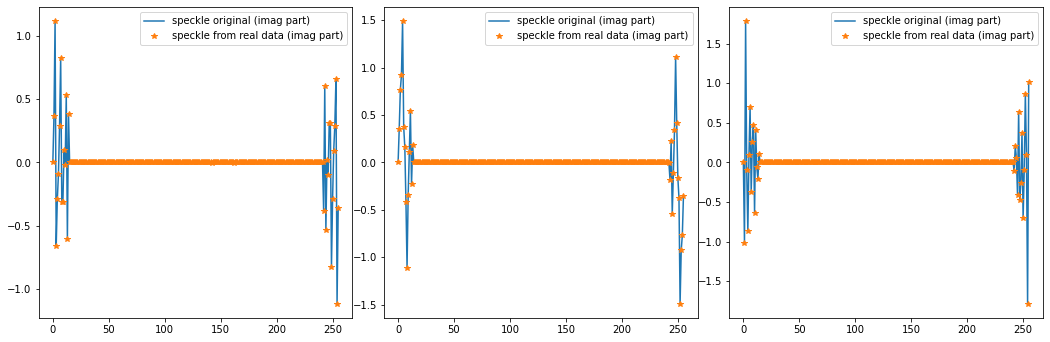

In [5]:
    rows = 2
    plt_num = 3

    fig = plt.figure(figsize=(6 * plt_num, 6*rows))
    fig.subplots_adjust(hspace=0.1, wspace=0.1)
    for num, image in enumerate(speckleF[:plt_num, :]):
        ax = fig.add_subplot(rows, plt_num, num + 1)
        ax.plot(-image.imag, '-', label='speckle original (imag part)')
        ax.plot(speckle_fou[num, :].imag, '*', label='speckle from real data (imag part)')
        plt.legend()

So, in order to be self consistent, one needs to apply the Pytorch's fft with normalization. As shown in plot and in the computed mean-difference beetween the original data and the transformation of the `speckleF`.

Difference beetween given real data and computed inverse of fourier data (real) tensor(0.0966, dtype=torch.float64)


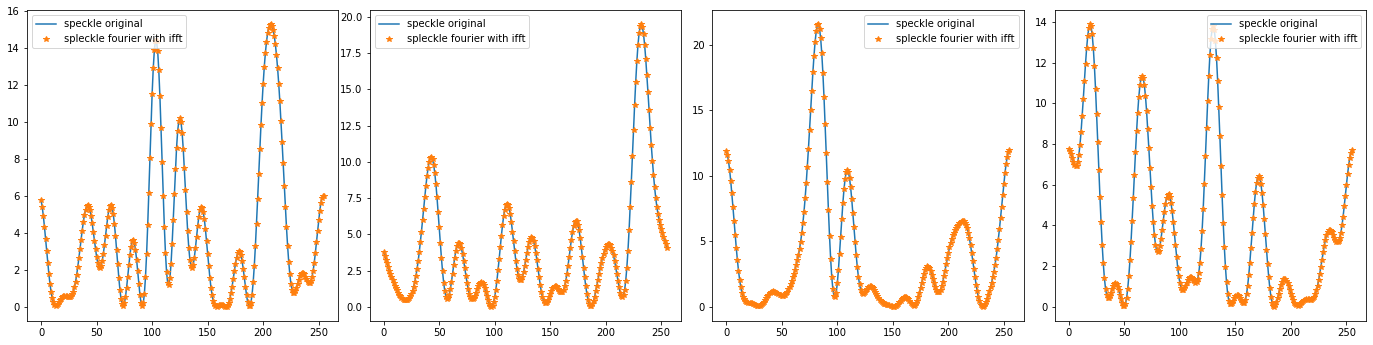

In [6]:
t = torch.fft.fft(speckleF,  dim=1, norm='backward')

print('Difference beetween given real data and computed inverse of fourier data (real)', torch.mean(torch.sum(((speckleR - t).abs()), dim=1)))

rows = 2
plt_num = 4

fig = plt.figure(figsize=(6 * plt_num, 6*rows))
fig.subplots_adjust(hspace=0.1, wspace=0.1)
for num, image in enumerate(speckleR[:plt_num, :]):
    ax = fig.add_subplot(rows, plt_num, num + 1)
    ax.plot(image, '-', label='speckle original')
    ax.plot(t[num], '*', label='spleckle fourier with ifft')
    plt.legend()


Let consider now the range of values of Fourier's input to point out whether a regularisation is required. This must be done for both real and imaginary part, since the neural network uses both during the training phase. 

No handles with labels found to put in legend.

MEANS 
Real part: 1.6684473081325933e-05
Imaginary part: -0.00012459338656200137
Total mean: -5.39544567403377e-05

STD 
Real part: 0.2217733741666949
Imaginary part: 0.05357039995581222
Total std: 0.13767188706125355

min and MAX
Real part: -3.4032508727554998    3.2374912320099876
Imaginary part: -3.2769245202923942    3.1480408244065154




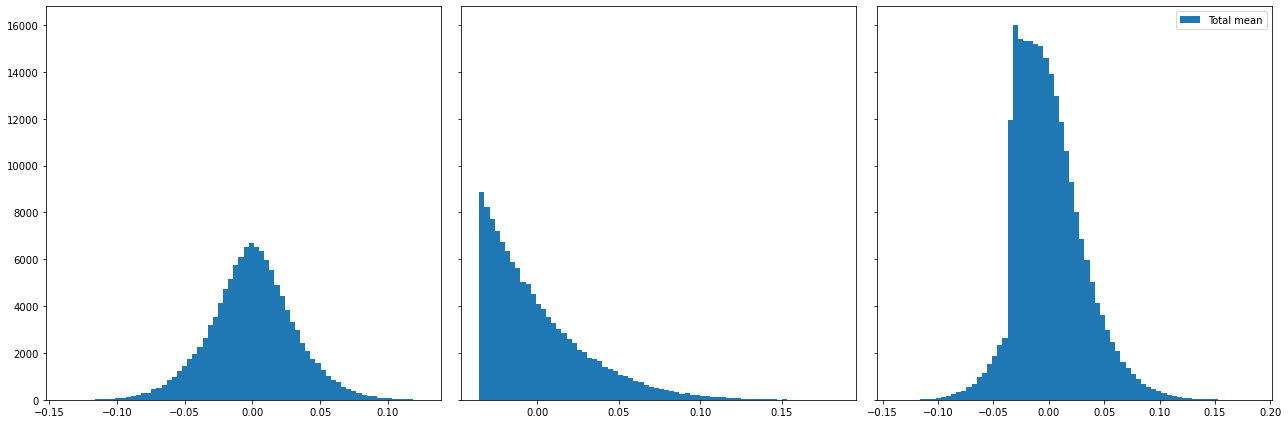

In [81]:
mean_imag = torch.mean(speckleF[...,1:57].imag, dim =1)
std_imag = torch.var(speckleF[...,1:57].imag, dim=1)

mean_real = torch.mean(speckleF[...,1:57].real, dim=1)
std_real = torch.std(speckleF[...,1:57].real, dim=1)

mean = torch.cat((mean_imag, mean_real), dim=0)
std = torch.cat((std_imag, std_real), dim=0)

real_min = torch.min(speckleF[...,1:57].real)
real_max = torch.max(speckleF[...,1:57].real)

imag_min = torch.min(speckleF[...,1:57].imag)
imag_max = torch.max(speckleF[...,1:57].imag)

fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=True, figsize=(18,6))
_ = axs[0].hist(mean_imag.numpy(), bins=70, label="Imaginary part")
plt.legend(loc='upper left')
_ = axs[1].hist(mean_real.numpy(), bins=70, label="Real part")
_ = axs[2].hist(mean.numpy(), bins=70, label="Total mean")
plt.legend(loc='upper right')

print("\nMEANS \nReal part: {0}\nImaginary part: {1}\nTotal mean: {2}\n".format(torch.mean(mean_real), torch.mean(mean_imag), torch.mean(mean)))
print("STD \nReal part: {0}\nImaginary part: {1}\nTotal std: {2}\n".format(torch.mean(std_real), torch.mean(std_imag), torch.mean(std)))

print("min and MAX\nReal part: {}    {}\nImaginary part: {}    {}\n\n".format(real_min, real_max, imag_min, imag_max))

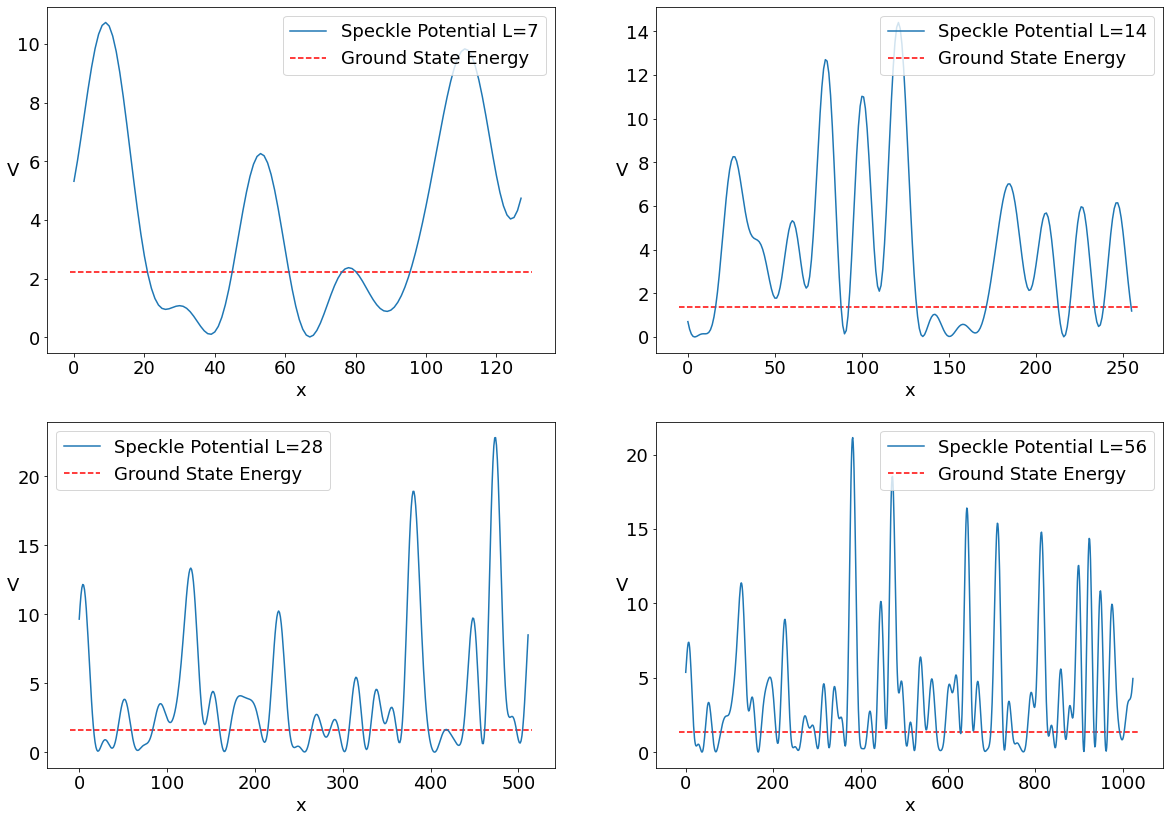

In [3]:
#print(speckleR.size())
train_7 = np.load('dataset/train_data_L7.npz')
train_28 = np.load('dataset/train_data_L28.npz')
train_14 = np.load('dataset/train_data_L14.npz')
train_56 = np.load('dataset/train_data_L56.npz')

fig = plt.figure(figsize=(20,14))
plt.rcParams.update({'font.size': 18})
#ax = np.arange(512)

plt.subplot(2,2,1)
#ax = np.arange(-64, 64)
ax = np.arange(0, 128)
plt.hlines(train_7['evalues'][8], xmin=-1, xmax=130, colors='red', linestyles='dashed', label='Ground State Energy')
#plt.plot(ax, np.fft.fftshift(np.fft.fft(train_7['speckleR'], norm='forward').imag)[5,:], label='Speckle Potential (Imag) L=7')
plt.plot(ax, train_7['speckleR'][8,:], '-', label='Speckle Potential L=7')
#plt.hlines(train_28['evalues'][5], xmin=-15, xmax=539, colors='red', linestyles='dashed', label='Ground State Energy')
plt.ylabel('V', rotation='horizontal')
plt.xlabel('x')
plt.legend(loc='upper right')

plt.subplot(2,2,2)
# ax = np.arange(-64, 64)
ax = np.arange(0,256)
#plt.plot(ax, np.fft.fftshift(np.fft.fft(train_14['speckleR'], norm='forward').imag)[6,64:192], label='Speckle Potential (Imag) L=14')
plt.plot(ax, train_14['speckleR'][8,:], '-', label='Speckle Potential L=14')
plt.hlines(train_14['evalues'][8], xmin=-5, xmax=260, colors='red', linestyles='dashed', label='Ground State Energy')
#plt.plot(ax, train_28['speckleR'][6,:], '-', label='Speckle Potential L=28')
#plt.hlines(train_28['evalues'][6], xmin=-15, xmax=539, colors='red', linestyles='dashed', label='Ground State Energy')
plt.ylabel('V', rotation='horizontal')
plt.xlabel('x')
plt.legend(loc='upper right')

plt.subplot(2,2,3)
# ax = np.arange(-64, 64)
ax = np.arange(0, 512)
plt.plot(ax, train_28['speckleR'][8,:], '-', label='Speckle Potential L=28')
# plt.plot(ax, np.fft.fftshift(np.fft.fft(train_28['speckleR'], norm='forward').imag)[7,192:320], '-', label='Speckle Potential (Imag) L=28')
#plt.plot(ax, train_28['speckleR'][7,:], '-', label='Speckle Potential L=28')
#plt.hlines(train_28['evalues'][7], xmin=-15, xmax=539, colors='red', linestyles='dashed', label='Ground State Energy')
#plt.plot(ax, np.fft.fftshift(np.fft.fft(train_28['speckleR'], norm='forward').imag)[5,192:320], '--', label='Speckle Potential () L=28')
plt.hlines(train_28['evalues'][8], xmin=-10, xmax=515, colors='red', linestyles='dashed', label='Ground State Energy')
plt.ylabel('V', rotation='horizontal')
plt.xlabel('x')
plt.legend(loc='upper left')

plt.subplot(2,2,4)
plt.hlines(train_56['evalues'][8], xmin=-15, xmax=1040, colors='red', linestyles='dashed', label='Ground State Energy')
# ax = np.arange(-64, 64)
ax = np.arange(0, 1024)
plt.plot(ax, train_56['speckleR'][8,:], '-', label='Speckle Potential L=56')
# plt.plot(ax, np.fft.fftshift(np.fft.fft(train_56['speckleR'], norm='forward').imag)[5,448:576], label='Speckle potential (Imag) L=56')
#plt.plot(ax, train_28['speckleR'][8,:], '-', label='Speckle Potential L=28')
plt.ylabel('V', rotation='horizontal')
plt.xlabel('x')
plt.legend(loc='upper right')

In [6]:
test56 = np.fft.fft(train_56['speckleR'], norm='forward')[:,1:57]
test7 = np.fft.fft(train_7['speckleR'], norm='forward')[:,1:8]
test28 = np.fft.fft(train_28['speckleR'], norm='forward')[:,1:29]
test14 = np.fft.fft(train_14['speckleR'], norm='forward')[:,1:15]

mean7_real = np.ravel(test7.real).mean()
mean14_real = np.ravel(test14.real).mean()
mean28_real = np.ravel(test28.real).mean()
mean56_real = np.ravel(test56.real).mean()

mean_real = np.concatenate((np.ravel(test56.real), np.ravel(test28.real), np.ravel(test14.real), np.ravel(test7.real))).mean()



mean7_imag = np.ravel(test7.imag).mean()
mean14_imag = np.ravel(test14.imag).mean()
mean28_imag = np.ravel(test28.imag).mean()
mean56_imag = np.ravel(test56.imag).mean()

mean_imag = np.concatenate((np.ravel(test56.imag), np.ravel(test28.imag), np.ravel(test14.imag), np.ravel(test7.imag))).mean()

mean7 = np.concatenate((np.ravel(test7.imag), np.ravel(test7.real))).mean()
mean14 = np.concatenate((np.ravel(test14.imag), np.ravel(test14.real))).mean()
mean28 = np.concatenate((np.ravel(test28.imag), np.ravel(test28.real))).mean()
mean56 = np.concatenate((np.ravel(test56.imag), np.ravel(test56.real))).mean()

mean = np.mean([mean_real, mean_imag])

sigma7_real = np.ravel(test7.real).std()
sigma14_real = np.ravel(test14.real).std()
sigma28_real = np.ravel(test28.real).std()
sigma56_real = np.ravel(test56.real).std()

std_real = np.concatenate((np.ravel(test56.real), np.ravel(test28.real), np.ravel(test14.real), np.ravel(test7.real))).std()

sigma7_imag = np.ravel(test7.imag).std()
sigma14_imag = np.ravel(test14.imag).std()
sigma28_imag = np.ravel(test28.imag).std()
sigma56_imag = np.ravel(test56.imag).std()

std_imag = np.concatenate((np.ravel(test56.imag), np.ravel(test28.imag), np.ravel(test14.imag), np.ravel(test7.imag))).std()

std7 = np.concatenate((np.ravel(test7.imag), np.ravel(test7.real))).std()
std14 = np.concatenate((np.ravel(test14.imag), np.ravel(test14.real))).std()
std28 = np.concatenate((np.ravel(test28.imag), np.ravel(test28.real))).std()
std56 = np.concatenate((np.ravel(test56.imag), np.ravel(test56.real))).std()

std = np.concatenate((np.ravel(test56.imag), np.ravel(test28.imag), np.ravel(test14.imag), np.ravel(test7.imag), np.ravel(test56.real), np.ravel(test28.real), np.ravel(test14.real), np.ravel(test7.real))).std()

In [5]:
print('\n\nREAL')
print(np.max(test7.real), np.max(test14.real), np.max(test28.real), np.max(test56.real))
print(np.min(test7.real), np.min(test14.real), np.min(test28.real), np.min(test56.real))

print('\n\nIMAG')
print(np.max(test7.imag), np.max(test14.imag), np.max(test28.imag), np.max(test56.imag))
print(np.min(test7.imag), np.min(test14.imag), np.min(test28.imag), np.min(test56.imag))

print('\nBOTH')
print(np.max(np.concatenate((test7.real, test7.imag))), np.max(np.concatenate((test14.real, test14.imag))), np.max(np.concatenate((test28.real, test28.imag))), np.max(np.concatenate((test56.real, test56.imag))))
print(np.min(np.concatenate((test7.real, test7.imag))), np.min(np.concatenate((test14.real, test14.imag))), np.min(np.concatenate((test28.real, test28.imag))), np.min(np.concatenate((test56.real, test56.imag))))

print('\n\nMEAN')
print(mean7_real, mean14_real, mean28_real, mean56_real)
print(mean7_imag, mean14_imag, mean28_imag, mean56_imag)
print(mean7, mean14, mean28, mean56)

print('\n\nSTD')
print(sigma7_real, sigma14_real, sigma28_real, sigma56_real)
print(sigma7_imag, sigma14_imag, sigma28_imag, sigma56_imag)
print(std7, std14, std28, std56)



REAL
3.237474347669032 2.7306924596797626 2.0336251663802516 1.4931577909580311
-3.403331349367293 -2.592350995572897 -2.167315764223231 -1.6771561803955464


IMAG
3.2769019702924895 2.843600078156192 2.2923546188898114 1.5350284780546366
-3.1480715609138454 -2.7295086672807196 -2.0787675329045543 -1.6218073952950374

BOTH
3.2769019702924895 2.843600078156192 2.2923546188898114 1.5350284780546366
-3.403331349367293 -2.7295086672807196 -2.167315764223231 -1.6771561803955464


MEAN
0.0001334461084800139 0.00010448685278244612 -0.0003870376820533658 0.0005194243981821272
0.0009967049963215137 -0.00010605152395153249 0.0003243420989643004 0.00023733480145955927
0.0005650755524007639 -7.823355845430459e-07 -3.134779154453262e-05 0.00037837959982084304


STD
0.6551461308367063 0.49962329252751253 0.3649398227456456 0.2627183845956194
0.6546726484440111 0.4996511574400035 0.3653024751806639 0.2627692754979975
0.6549095746662112 0.4996372362676603 0.36512136723926414 0.2627438691364126


In [6]:
print("mean, std", mean, std)

mean, std 0.00017965349968347114 0.43636118322494044


In [29]:
stand_test = test56.real - mean56_real
print(stand_test.mean())
stand_test = stand_test / sigma56_real
print(stand_test.std())

1.691768418476429e-19
1.0


In [7]:
norm_test = (test56.real - np.min(test56.real)) / (np.max(test56.real) - np.min(test56.real))
print(np.ravel(norm_test).max())
print(norm_test.mean(), norm_test.std())
print(np.ravel(norm_test).max(), np.ravel(norm_test).min())

1.0
0.5291827938661352 0.08286825436518228
1.0 0.0


In [12]:
stand_norm_test = (norm_test - 0.5) / 0.5

print(stand_norm_test.mean(), stand_norm_test.std())
print(np.ravel(stand_norm_test).max(), np.ravel(stand_norm_test).min())

0.058365587732270345 0.16573650873036455
1.0 -1.0


In [9]:
np.ravel((norm_test + np.min(test56.real)) / (np.max(test56.real) - np.min(test56.real))).mean()

-0.36210085086281846

In [41]:
print((mean56_real - np.min(test56.real)) / (np.max(test56.real) - np.min(test56.real)))
print(sigma56_real / (np.max(test56.real) - np.min(test56.real)))

0.5291827938661352
0.08286825436518226


In [7]:
test56_reshape = np.zeros((test56.shape[0], 56), dtype=complex)
test56_reshape[..., :] = test56
test28_reshape = np.zeros((test28.shape[0], 56), dtype=complex)
test28_reshape[..., 1::2] = test28
test14_reshape = np.zeros((test14.shape[0], 56), dtype=complex)
test14_reshape[..., 3::4] = test14
test7_reshape = np.zeros((test7.shape[0], 56), dtype=complex)
test7_reshape[..., 7::8] = test7

dataset = [test7_reshape, test14_reshape, test28_reshape, test56_reshape]
dataset_new = []
for el in dataset:
    real_ds = np.real(el)
    imag_ds = np.imag(el)
    data = np.zeros((el.shape[0], 112))
    data[..., ::2] = real_ds
    data[..., 1::2] = imag_ds
    dataset_new.append(data)

del dataset

In [8]:
del test7_reshape, test14_reshape, test28_reshape, test56_reshape

In [7]:
del dataset

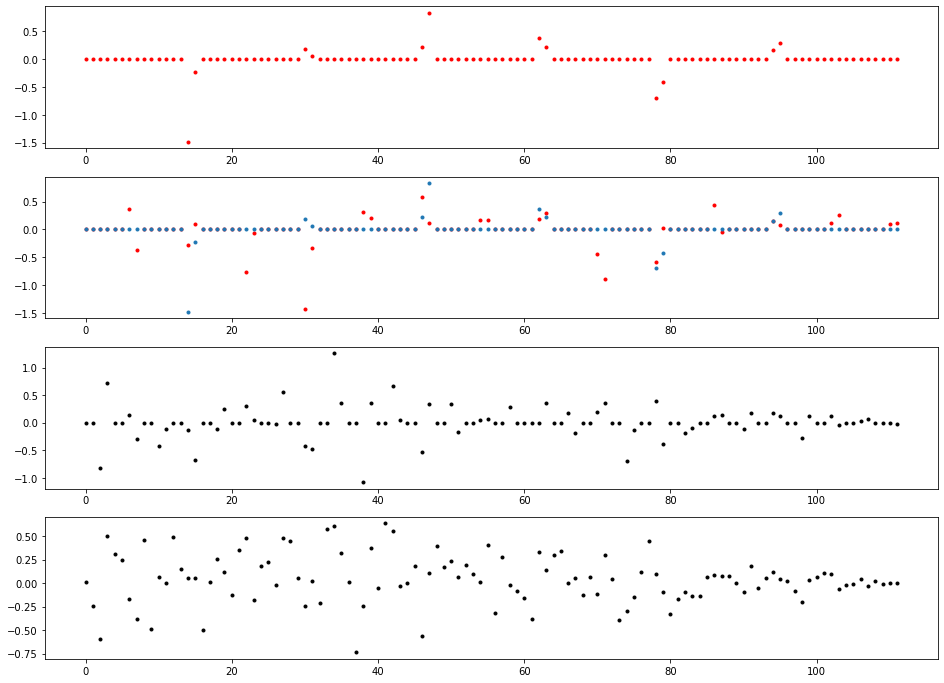

In [9]:
#test14_reshape[5,test14_reshape[5,:]==0] = None

fig = plt.figure(figsize=(16,12))

plt.subplot(4,1,1)
plt.plot(dataset_new[0][5,:], '.', color='red')
#plt.plot(test14_reshape[5,test14_reshape[5,:]==0], '.', color='red')

plt.subplot(4,1,2)
plt.plot(dataset_new[1][5,:], '.', color='red', label='L14')
plt.plot(dataset_new[0][5,:], '.', label='L7')

plt.subplot(4,1,3)
plt.plot(dataset_new[2][5,:], '.', color='black')

plt.subplot(4,1,4)
plt.plot(dataset_new[3][5,:], '.', color='black')

#plt.hlines(0, xmin=-3, xmax=112, linewidth=3, color='black')

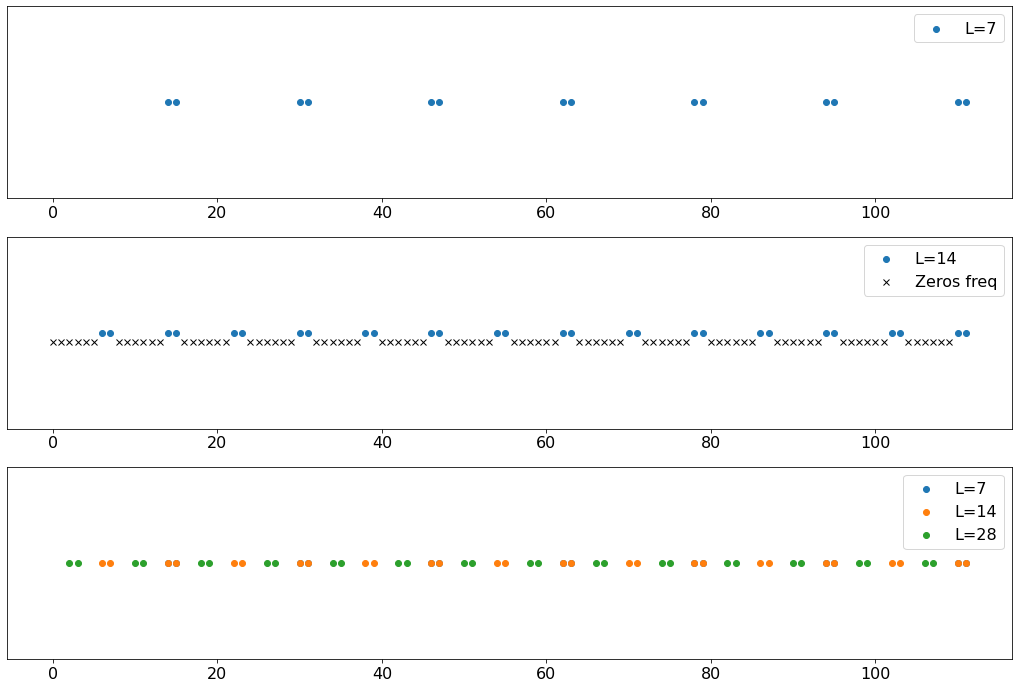

In [13]:
fig = plt.figure(figsize=(18,12))
plt.rcParams.update({'font.size': 16})

plt.subplot(3,1,1)
array2plot7 = np.full(dataset_new[0][5,:].shape, None)
array2plot7[dataset_new[0][5,:]!=0] = 1
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,
    left=False,     # ticks along the bottom edge are off
    labelbottom=True,
    labelleft=False,) 
plt.scatter(range(112), array2plot7, label='L=7', linewidths=1)
# plot7 = np.full(dataset_new[0][5,:].shape, None)
# plot7[array2plot7 != 1] = 0.9
plt.ylim(0, 2)
#plt.scatter(range (112), plot7, linewidths=1, marker="x", c="black", label="Zeros freq") 
plt.legend()


plt.subplot(3,1,2)
array2plot14 = np.full(dataset_new[0][5,:].shape, None)
array2plot14[np.logical_and(dataset_new[1][5,:]!=0, dataset_new[0][5,:]==0)] = 1
array2plot14[dataset_new[1][5,:]!=0] = 1
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,
    left=False,     # ticks along the bottom edge are off
    labelbottom=True,
    labelleft=False,) 
#plt.scatter(range(112), array2plot7, label='L=7')
plt.scatter(range(112), array2plot14, label='L=14', linewidths=1)
plot7 = np.full(dataset_new[0][5,:].shape, None)
plot7[np.logical_and(array2plot14 != 1, array2plot7 != 1)] = 0.9
plt.ylim(0, 2)
plt.scatter(range (112), plot7, linewidths=1, marker="x", c="black", label="Zeros freq") 
plt.legend()


plt.subplot(3,1,3)
array2plot28 = np.full(dataset_new[0][5,:].shape, None)
array2plot28[np.logical_and(dataset_new[2][5,:]!=0, np.logical_and(dataset_new[0][5,:]==0, dataset_new[1][5,:]==0))] = 1
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,
    left=False,     # ticks along the bottom edge are off
    labelbottom=True,
    labelleft=False,) 
plt.scatter(range(112), array2plot7, label='L=7', linewidths=1)
plt.scatter(range(112), array2plot14, label='L=14', linewidths=1)
plt.scatter(range(112), array2plot28, label='L=28', linewidths=1)
plt.legend()

In [3]:
train_28 = np.load('dataset/train_data_L28.npz')

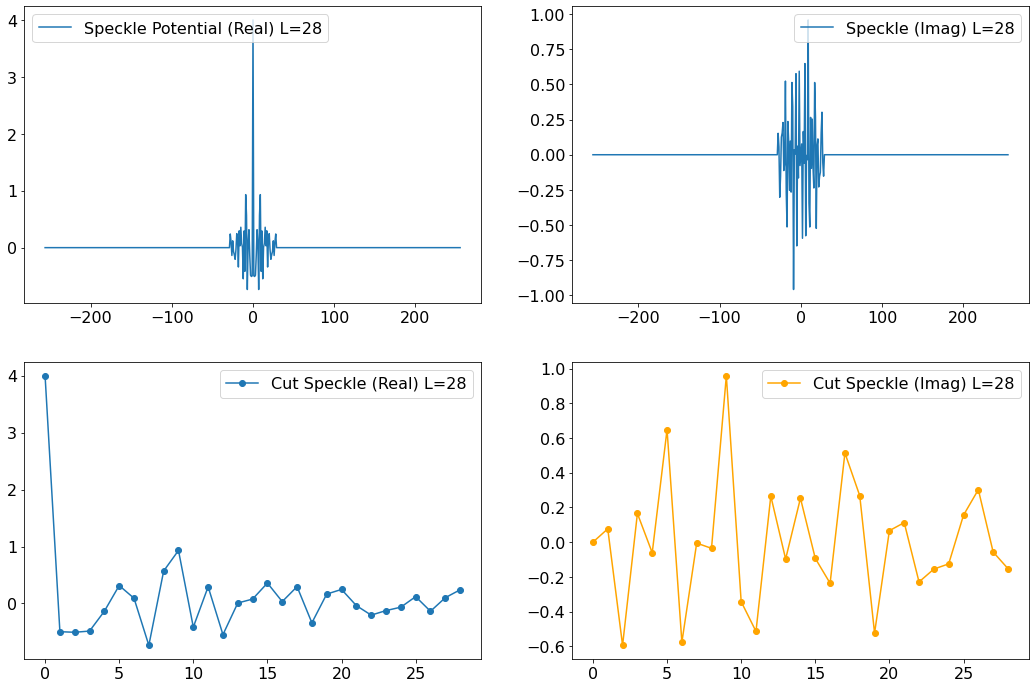

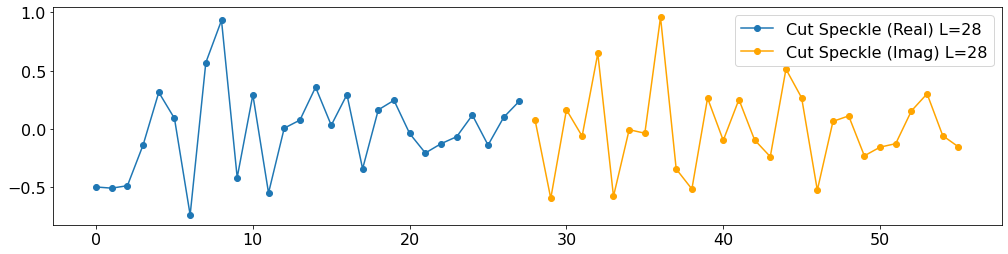

In [6]:
plt.figure(figsize=(18,12))
plt.rcParams.update({'font.size': 16})

#[5,192:320]

plt.subplot(2,2,1)
ax = np.arange(-256, 256)
plt.plot(ax, np.fft.fftshift(np.fft.fft(train_28['speckleR'], norm='forward').real)[5,:], '-', label='Speckle Potential (Real) L=28')
#plt.plot(ax, np.fft.fftshift(np.fft.fft(train_28['speckleR'], norm='forward').imag)[5,192:320], '--', label='Speckle Potential () L=28')
# plt.hlines(train_28['evalues'][5], xmin=-10, xmax=515, colors='red', linestyles='dashed', label='Ground State Energy')
plt.legend(loc='upper left')

plt.subplot(2,2,2)
ax = np.arange(-256, 256)
#plt.plot(ax, np.fft.fftshift(np.fft.fft(train_28['speckleR'], norm='forward').real)[5,192:320], '--', label='Speckle Potential (Real) L=28')
plt.plot(ax, np.fft.fftshift(np.fft.fft(train_28['speckleR'], norm='forward').imag)[5,:], '-', label='Speckle (Imag) L=28')
# plt.hlines(train_28['evalues'][5], xmin=-10, xmax=515, colors='red', linestyles='dashed', label='Ground State Energy')
plt.legend(loc='upper right')


plt.subplot(2,2,3)
ax = np.arange(29)
plt.plot(ax, np.fft.fftshift(np.fft.fft(train_28['speckleR'], norm='forward').real)[5,256:285], 'o-', label='Cut Speckle (Real) L=28')
#plt.plot(ax, np.fft.fftshift(np.fft.fft(train_28['speckleR'], norm='forward').imag)[5,:], '-', label='Speckle Potential (Imaginary) L=28')
# plt.hlines(train_28['evalues'][5], xmin=-10, xmax=515, colors='red', linestyles='dashed', label='Ground State Energy')
plt.legend(loc='best')

plt.subplot(2,2,4)
ax = np.arange(29)
#plt.plot(ax, np.fft.fftshift(np.fft.fft(train_28['speckleR'], norm='forward').real)[5,192:320], '--', label='Speckle Potential (Real) L=28')
plt.plot(ax, np.fft.fftshift(np.fft.fft(train_28['speckleR'], norm='forward').imag)[5,256:285], 'o-', color='orange', label='Cut Speckle (Imag) L=28')
# plt.hlines(train_28['evalues'][5], xmin=-10, xmax=515, colors='red', linestyles='dashed', label='Ground State Energy')
plt.legend(loc='best')

plt.figure(figsize=(17,4))
plt.plot(np.arange(0,28), np.fft.fftshift(np.fft.fft(train_28['speckleR'], norm='forward').real)[5,257:285], 'o-', label='Cut Speckle (Real) L=28')
plt.plot(np.arange(28,56), np.fft.fftshift(np.fft.fft(train_28['speckleR'], norm='forward').imag)[5,257:285], 'o-', color='orange', label='Cut Speckle (Imag) L=28')
plt.legend(loc='best')

## Plot of the results varying the size of the dataset
Initialize with weights from trainig with both $L=7$ and $L=14$

In [7]:
result_init = np.array(
               [[0.622715, 0.820302, 0.898719, -185.093], 
               [0.685142, 0.897577, 0.956511, -163.819],
               [0.801066, 0.933743, 0.977197, -547.408], 
               [0.814715, 0.944821, 0.984102, -7698.66], 
               [0.826885, 0.932859, 0.988114, -235254.4],
               [0.82445, 0.96424, 0.990494, -8526.06],
               [0.82317, 0.809632, 0.992523, -1e7],
               [0.758208, 0.227778, 0.990750, -2.21e7],
              ])
result_init2 = np.array([[0.526374, 0.760958, 0.786207, -6.32379],
                        [0.597884, 0.827696, 0.879996, -7.22399],
                        [0.732581, 0.746144, 0.950762, -7.71609],
                        [0.820043, 0.91624, 0.979708, -8.15014],
                        [0.887502, 0.955264, 0.983844, -8.53037],
                        [0.850713, 0.909955, 0.988972, -8.55732],
                        [0.858847, 0.960934, 0.984226, -8.6445],
                        [0.824993, 0.491481, 0.981418, -8.37293],
                        ])


dataset_size = np.arange(0.3, 0.99, 0.1) * 60000
dataset_size = np.append(dataset_size, 60000)
system_sizes = ['L=7', 'L=14', 'L=28', 'L=56']

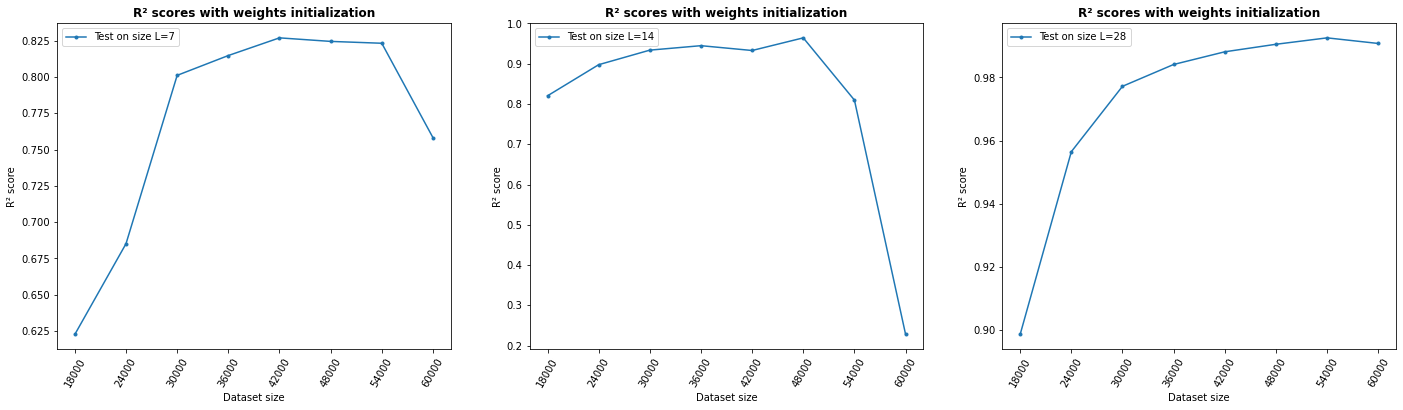

In [8]:
fig = plt.figure(figsize=(24,6))
for j, size in enumerate(system_sizes):
    if size == 'L=56':
        continue
    plt.subplot(1,3, j+1)
    plt.plot(dataset_size, result_init[:,j], '.-', label='Test on size {}'.format(size))
    _, _ = plt.xticks(dataset_size, rotation=60)
    plt.xlabel("Dataset size")
    plt.ylabel("R\xb2 score")
    plt.title("R\xb2 scores with weights initialization", fontweight="bold")
    plt.legend()

In [10]:
result_standnorm = np.array([
                    [0.607519, 0.817275, 0.9012, -160.01], 
                    [0.722584, 0.911101, 0.962075, -529.278], 
                    [0.776214, 0.931854, 0.976523, -216.082], 
                    [0.793762, 0.952586, 0.984801, -255.217], 
                    [0.822237, 0.962879, 0.989052, -673.384],
                    [0.82702, 0.965039, 0.990435, -1117.7],
                    [0.835124, 0.950155, 0.992408, -80690.2],
                    [0.857931, 0.908675, 0.993178, -1.018e5],
                    ])
result_noinit = np.array([
                        [0.651682, 0.843721, 0.891496, -7.81998],
                        [0.686142, 0.892523, 0.945878, -7.81216],
                        [0.769826, 0.934694, 0.972425, -8.2288],
                        [0.790257, 0.946989, 0.980373, -8.29459],
                        [0.825441, 0.960225, 0.987674, -8.25763],
                        [0.839082, 0.967238, 0.991861, -8.3371],
                        [0.847646, 0.969483, 0.99345, -8.29349],
                        [0.86841, 0.973221, 0.993851, -8.55609],
                        ])


dataset_size = np.arange(0.3, 0.99, 0.1) * 60000
dataset_size = np.append(dataset_size, 60000)
system_sizes = ['L=7', 'L=14', 'L=28', 'L=56']

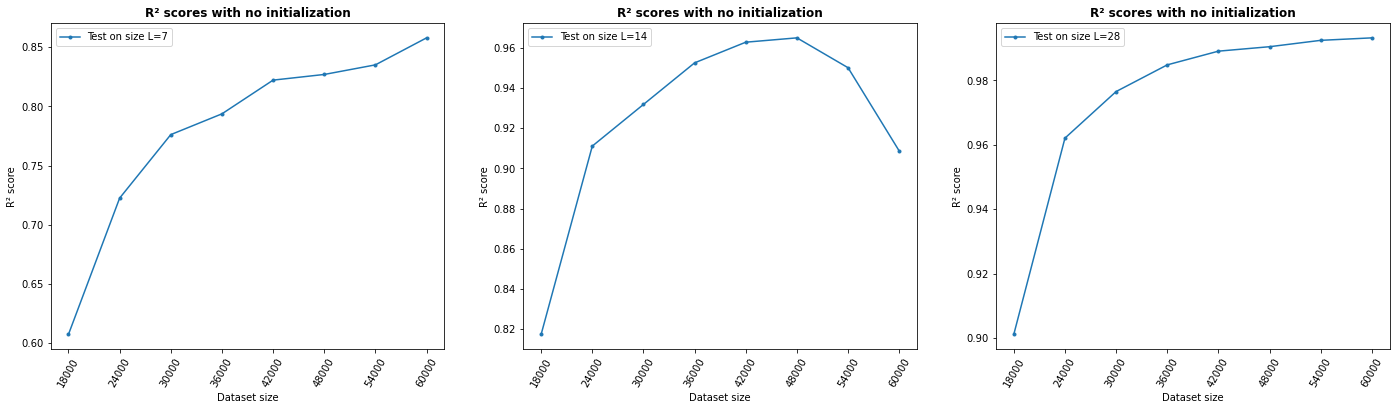

In [11]:
fig = plt.figure(figsize=(24,6))
for j, size in enumerate(system_sizes):
    if size == 'L=56':
        continue
    plt.subplot(1,3, j+1)
    plt.plot(dataset_size, result_standnorm[:,j], '.-', label='Test on size {}'.format(size))
    _, _ = plt.xticks(dataset_size, rotation=60)
    plt.xlabel("Dataset size")
    plt.ylabel("R\xb2 score")
    plt.title("R\xb2 scores with no initialization", fontweight="bold")
    plt.legend()

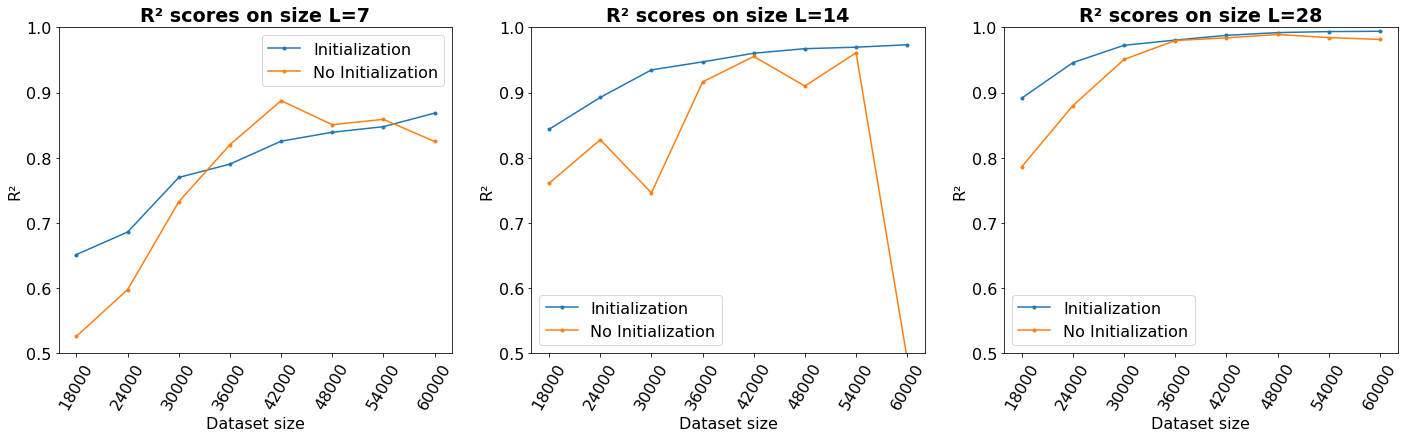

In [17]:
fig = plt.figure(figsize=(24,6))
plt.rcParams.update({'font.size': 16})

for j, size in enumerate(system_sizes):
    if size == 'L=56':
        continue
    plt.subplot(1,3, j+1)
    plt.plot(dataset_size, result_noinit[:,j], '.-', label='Initialization')
    plt.plot(dataset_size, result_init2[:,j], '.-', label='No Initialization')
    _, _ = plt.xticks(dataset_size, rotation=60)
    plt.xlabel("Dataset size")
    plt.ylim(0.50, 1)
    plt.ylabel("R\xb2")
    plt.title("R\xb2 scores on size {0}".format(size), fontweight="bold")
    plt.legend()

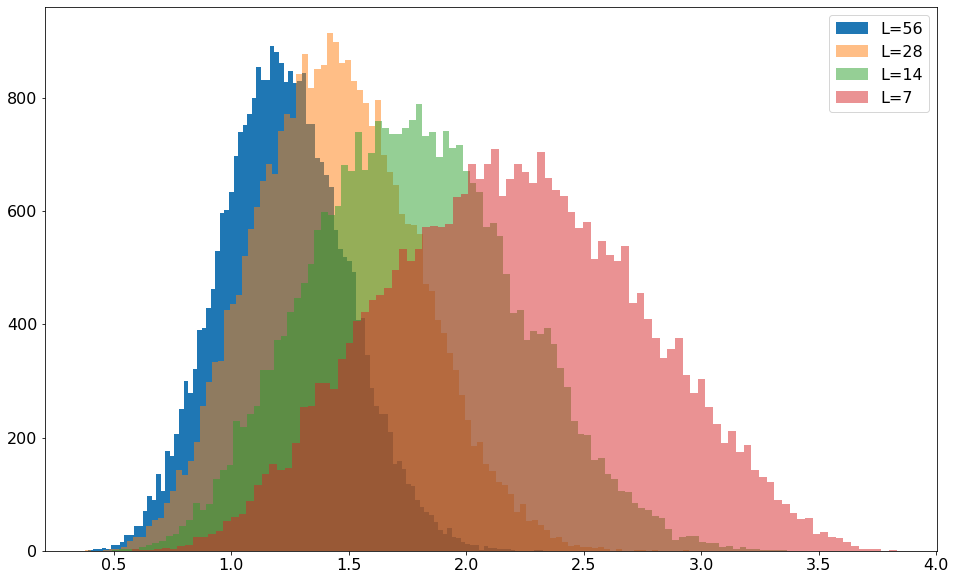

In [29]:
fig = plt.figure(figsize=(16,10))
_ = plt.hist(train_56['evalues'], bins=100, label="L=56")
_ = plt.hist(train_28['evalues'][:30000], bins=100, alpha = 0.5, label="L=28")
_ = plt.hist(train_14['evalues'][:30000], bins=100, alpha = 0.5, label="L=14")
_ = plt.hist(train_7['evalues'][:30000], bins=100, alpha = 0.5, label="L=7")
plt.legend()

In [27]:
print(np.mean(train_56['evalues']), np.std(train_56['evalues']))
print(np.mean(train_28['evalues'][:30000]), np.std(train_28['evalues'][:30000]))
print(np.mean(train_14['evalues'][:30000]), np.std(train_14['evalues'][:30000]))
print(np.mean(train_7['evalues'][:30000]), np.std(train_7['evalues'][:30000]))


1.2216983201681564 0.26362958219488297
1.4488369061738577 0.33878908121478324
1.781024214138319 0.4327364566027585
2.197999633167554 0.5422746688570776
